In [1]:
import tensorflow as tf

# IMPORTANTE: Dejad este conjunto de lineas #
gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus:
    tf.config.experimental.set_memory_growth(gpu, True)
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))
#############################################

Num GPUs Available:  2


In [2]:
import pandas as pd
import seaborn as sns
import numpy as np
import datetime

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error
import matplotlib.pyplot as plt

In [3]:
datapath = "data/pvpcdata.csv"
day = 24

In [4]:
df = pd.read_csv(datapath, sep = ";")

In [5]:
#Due to the hour format is between 0 to 23, we need to transform it
for i in df.index:
        df.at[i, 'hour'] = df.at[i, 'hour'] - 1

In [6]:
#To keep only valid valued, not the unusual ones
df = df.loc[df['hour'] < 24]

In [7]:
cols = ["year","month","day"]
df['date'] = df[cols].apply(lambda x: '-'.join(x.values.astype(str)), axis="columns")

In [8]:
df.head()

,year,month,day,hour,price,date
0,2017,1,1,0,58.82,2017-1-1
1,2017,1,1,1,58.23,2017-1-1
2,2017,1,1,2,51.95,2017-1-1
3,2017,1,1,3,47.27,2017-1-1
4,2017,1,1,4,46.90,2017-1-1


In [9]:
df['date'] = pd.to_datetime(df['date'].astype(str) + ' ' + df['hour'].astype(str) + ":00:00")

[Text(0.5, 1.0, 'Energy prices per hour at the last day')]

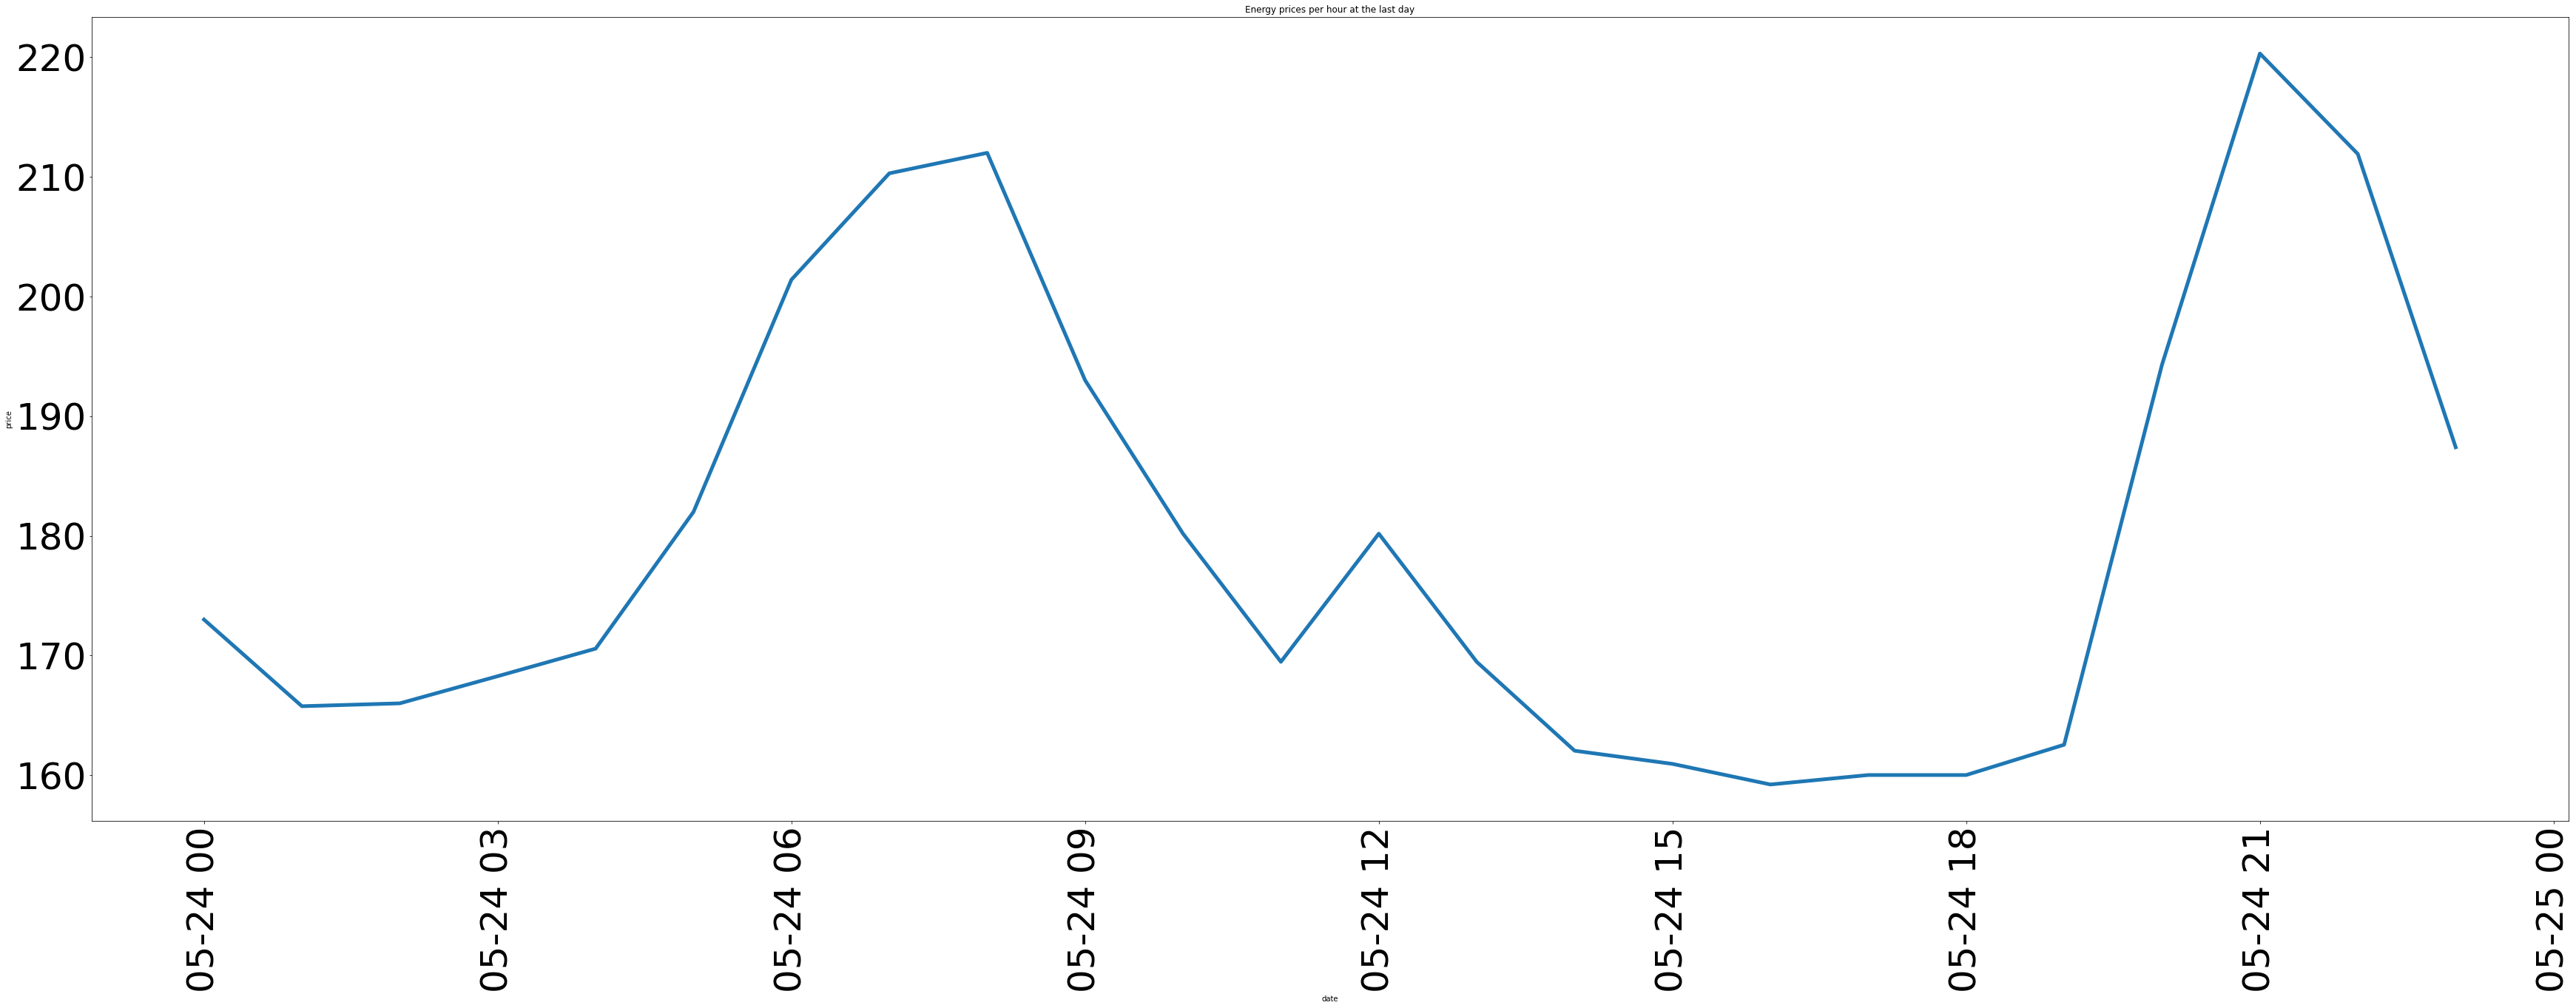

In [10]:
fig, ax = plt.subplots(figsize=(60,20))
plt.xticks(rotation=90, fontsize=50) 
plt.yticks(fontsize=50)
sns.lineplot(x = 'date', y = 'price', data = df.tail(day), linewidth = 5, ax = ax).set(title='Energy prices per hour at the last day')

In [11]:
df = df[['price']]

In [12]:
#Tamaño de ventana de 5
w_size = 5

#Número de entradas
n_inputs = len(df.columns)

In [13]:
# Método de la ventana, parámetro único en X
# Aquí podemos ver como dadas 5 horas, predice la siguiente
# [1,2,3,4,5] --> [6]
# [2,3,4,5,6] --> [7]

def df_to_x_y(df, w_size):
    df_as_np = df.to_numpy()
    x = []
    y = []
    
    #Bucle para construir nuestra ventana simple
    for i in range(len(df_as_np) - w_size):
        row = [[a] for a in df_as_np[i:i + w_size]]
        x.append(row)
        label = df_as_np[i + w_size]
        y.append(label)
    
    return np.array(x), np.array(y)

In [14]:
x, y = df_to_x_y(df, w_size)
x.shape, y.shape

((47293, 5, 1, 1), (47293, 1))

In [15]:
x_train, x_aux, y_train, y_aux = train_test_split(x, y, test_size = 0.3, shuffle=False)
x_test, x_val, y_test, y_val = train_test_split(x_aux, y_aux, test_size = 0.33, shuffle=False)

In [16]:
x_train.shape, y_train.shape, x_test.shape, y_test.shape, x_val.shape, y_val.shape

((33105, 5, 1, 1),
 (33105, 1),
 (9505, 5, 1, 1),
 (9505, 1),
 (4683, 5, 1, 1),
 (4683, 1))

In [17]:
def build_model_lstm():
    model = tf.keras.Sequential()
    model.add(tf.keras.layers.InputLayer((w_size, n_inputs)))
    model.add(tf.keras.layers.LSTM(64))
    model.add(tf.keras.layers.Dense(8, 'relu'))
    model.add(tf.keras.layers.Dense(1, 'linear'))
    model.compile(
        loss = 'mean_squared_error',
        optimizer = tf.keras.optimizers.Adam(0.001),
        metrics = ['mae', 'mse']
    )
    return model

In [18]:
def build_model_cnn():
    model = tf.keras.Sequential()
    model.add(tf.keras.layers.InputLayer((w_size, n_inputs)))
    model.add(tf.keras.layers.Conv1D(64, kernel_size = 2))
    model.add(tf.keras.layers.Flatten())
    model.add(tf.keras.layers.Dense(8, 'relu'))
    model.add(tf.keras.layers.Dense(1, 'linear'))
    model.compile(
        loss = 'mean_squared_error',
        optimizer = tf.keras.optimizers.Adam(0.001),
        metrics = ['mae', 'mse']
    )
    return model

In [19]:
def build_model_gru():
    model = tf.keras.Sequential()
    model.add(tf.keras.layers.InputLayer((w_size, n_inputs)))
    model.add(tf.keras.layers.GRU(64))
    model.add(tf.keras.layers.Dense(8, 'relu'))
    model.add(tf.keras.layers.Dense(1, 'linear'))
    model.compile(
        loss = 'mean_squared_error',
        optimizer = tf.keras.optimizers.Adam(0.001),
        metrics = ['mae', 'mse']
    )
    return model

In [20]:
model_lstm = build_model_lstm()
model_cnn = build_model_cnn()
model_gru = build_model_gru()

2022-06-07 11:02:22.751812: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-06-07 11:02:23.734937: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1525] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 17513 MB memory:  -> device: 0, name: Tesla V100-PCIE-32GB, pci bus id: 0000:5b:00.0, compute capability: 7.0
2022-06-07 11:02:23.736121: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1525] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 26273 MB memory:  -> device: 1, name: Tesla V100-PCIE-32GB, pci bus id: 0000:d7:00.0, compute capability: 7.0


In [21]:
callback = tf.keras.callbacks.EarlyStopping(monitor='loss', mode='auto', restore_best_weights=True, patience=15)

In [22]:
history_lstm = model_lstm.fit(
    x_train,
    y_train,
    validation_data = (x_val, y_val),
    epochs = 200,
    verbose = 1,
    shuffle = False,
    callbacks = callback
)

Epoch 1/200


2022-06-07 11:02:25.600187: I tensorflow/stream_executor/cuda/cuda_dnn.cc:366] Loaded cuDNN version 8100


1035/1035 [==============================] - 10s 8ms/step - loss: 308.1489 - mae: 9.9250 - mse: 308.1489 - val_loss: 30269.8516 - val_mae: 158.6012 - val_mse: 30269.8516
Epoch 2/200
1035/1035 [==============================] - 8s 8ms/step - loss: 11.1884 - mae: 2.1577 - mse: 11.1884 - val_loss: 25573.1309 - val_mae: 143.8768 - val_mse: 25573.1309
Epoch 3/200
1035/1035 [==============================] - 8s 8ms/step - loss: 8.2579 - mae: 1.9581 - mse: 8.2579 - val_loss: 23999.1133 - val_mae: 138.5349 - val_mse: 23999.1133
Epoch 4/200
1035/1035 [==============================] - 8s 7ms/step - loss: 7.8017 - mae: 1.9276 - mse: 7.8017 - val_loss: 22774.3008 - val_mae: 134.3106 - val_mse: 22774.3008
Epoch 5/200
1035/1035 [==============================] - 8s 7ms/step - loss: 7.4927 - mae: 1.9096 - mse: 7.4927 - val_loss: 22208.8926 - val_mae: 132.4750 - val_mse: 22208.8926
Epoch 6/200
1035/1035 [==============================] - 8s 7ms/step - loss: 7.5065 - mae: 1.8984 - mse: 7.5065 - val_lo

In [23]:
history_cnn = model_cnn.fit(
    x_train,
    y_train,
    validation_data = (x_val, y_val),
    epochs = 200,
    verbose = 1,
    shuffle = False,
    callbacks = callback
)

Epoch 1/200
1035/1035 [==============================] - 6s 5ms/step - loss: 57.2543 - mae: 4.2682 - mse: 57.2543 - val_loss: 674.9758 - val_mae: 18.1825 - val_mse: 674.9758
Epoch 2/200
1035/1035 [==============================] - 6s 5ms/step - loss: 11.5886 - mae: 2.2960 - mse: 11.5886 - val_loss: 405.6581 - val_mae: 14.1933 - val_mse: 405.6581
Epoch 3/200
1035/1035 [==============================] - 6s 5ms/step - loss: 7.7080 - mae: 1.8705 - mse: 7.7080 - val_loss: 366.2757 - val_mae: 13.6857 - val_mse: 366.2757
Epoch 4/200
1035/1035 [==============================] - 6s 5ms/step - loss: 7.0846 - mae: 1.8035 - mse: 7.0846 - val_loss: 457.9266 - val_mae: 16.3262 - val_mse: 457.9266
Epoch 5/200
1035/1035 [==============================] - 6s 5ms/step - loss: 7.1281 - mae: 1.8229 - mse: 7.1281 - val_loss: 513.8383 - val_mae: 17.7328 - val_mse: 513.8383
Epoch 6/200
1035/1035 [==============================] - 6s 5ms/step - loss: 7.1568 - mae: 1.8314 - mse: 7.1568 - val_loss: 542.8083 - v

In [24]:
history_gru = model_gru.fit(
    x_train,
    y_train,
    validation_data = (x_val, y_val),
    epochs = 200,
    verbose = 1,
    shuffle = False,
    callbacks = callback
)

Epoch 1/200
1035/1035 [==============================] - 9s 7ms/step - loss: 293.0466 - mae: 9.4197 - mse: 293.0466 - val_loss: 33984.7617 - val_mae: 169.6265 - val_mse: 33984.7617
Epoch 2/200
1035/1035 [==============================] - 7s 7ms/step - loss: 9.7959 - mae: 2.0353 - mse: 9.7959 - val_loss: 31242.0449 - val_mae: 161.0252 - val_mse: 31242.0449
Epoch 3/200
1035/1035 [==============================] - 7s 7ms/step - loss: 7.8985 - mae: 1.9174 - mse: 7.8985 - val_loss: 30779.6328 - val_mae: 160.0298 - val_mse: 30779.6328
Epoch 4/200
1035/1035 [==============================] - 7s 7ms/step - loss: 7.3901 - mae: 1.8820 - mse: 7.3901 - val_loss: 30126.0566 - val_mae: 158.0253 - val_mse: 30126.0566
Epoch 5/200
1035/1035 [==============================] - 7s 7ms/step - loss: 7.0630 - mae: 1.8517 - mse: 7.0630 - val_loss: 29479.2227 - val_mae: 156.2249 - val_mse: 29479.2227
Epoch 6/200
1035/1035 [==============================] - 7s 7ms/step - loss: 6.9945 - mae: 1.8435 - mse: 6.9945

In [25]:
def plot_history(history, y_min, y_loss, y_mae, y_mse):
    hist = pd.DataFrame(history.history)
    hist['epoch'] = history.epoch
    
    #Graphic of Loss
    plt.figure()
    plt.xlabel('Epoch')
    plt.ylabel('Loss Function')
    plt.plot(hist['epoch'], hist['loss'], label='Loss Error')
    plt.plot(hist['epoch'], hist['val_loss'], label = 'Val Error')
    plt.ylim([y_min,y_loss])
    plt.legend()
    
    #Graphic of MAE
    plt.figure()
    plt.xlabel('Epoch')
    plt.ylabel('Mean Abs Error [MPG]')
    plt.plot(hist['epoch'], hist['mae'], label='Train Error')
    plt.plot(hist['epoch'], hist['val_mae'], label = 'Val Error')
    plt.ylim([y_min,y_mae])
    plt.legend()
    
    #Graphic of MSE
    plt.figure()
    plt.xlabel('Epoch')
    plt.ylabel('Mean Square Error [$MPG^2$]')
    plt.plot(hist['epoch'], hist['mse'], label='Train Error')
    plt.plot(hist['epoch'], hist['val_mse'], label = 'Val Error')
    plt.ylim([y_min,y_mse])
    plt.legend()
    
    
    plt.show()

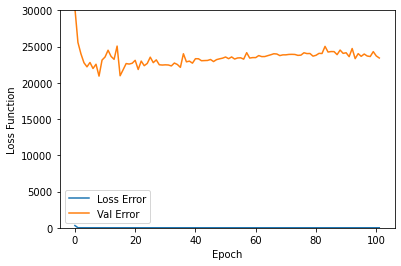

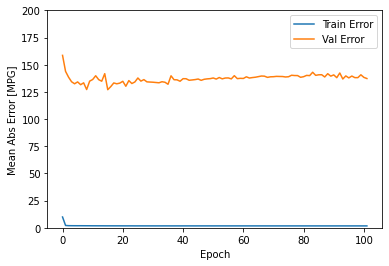

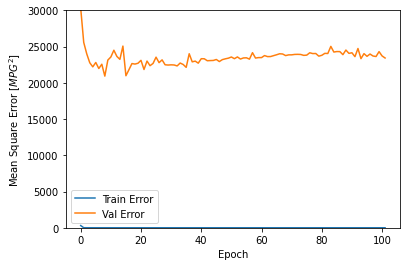

In [26]:
plot_history(history_lstm, 0, 30000, 200, 30000)

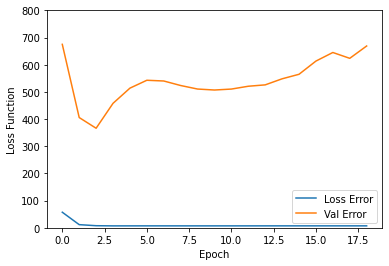

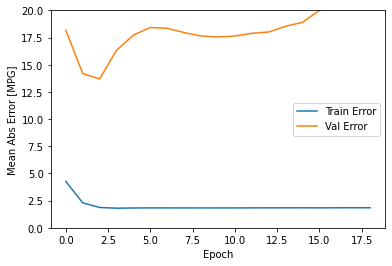

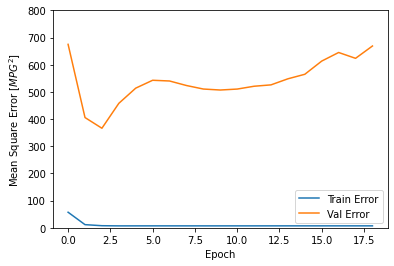

In [27]:
plot_history(history_cnn, 0, 800, 20, 800)

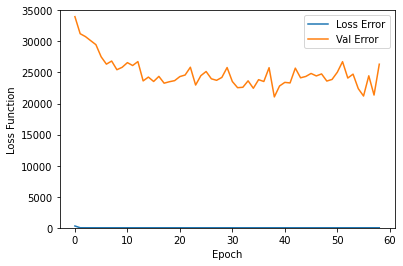

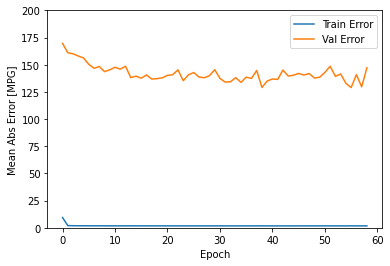

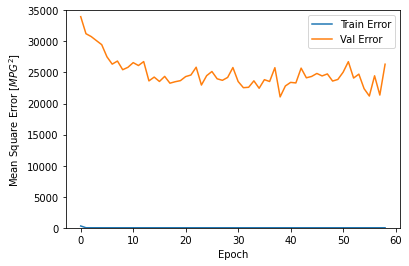

In [28]:
plot_history(history_gru, 0, 35000, 200, 35000)

In [29]:
y_pred_lstm = model_lstm.predict(x_test)
y_pred_cnn = model_cnn.predict(x_test)
y_pred_gru = model_gru.predict(x_test)

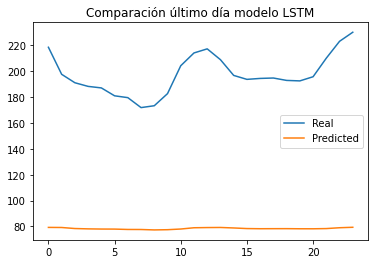

In [30]:
plt.plot(y_test[((y_test.size) - 24):], label='Real')
plt.plot(y_pred_lstm[((y_test.size) - 24):], label='Predicted')
plt.title("Comparación último día modelo LSTM")
plt.legend()

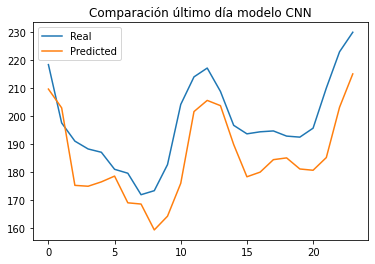

In [31]:
plt.plot(y_test[((y_test.size) - 24):], label='Real')
plt.plot(y_pred_cnn[((y_test.size) - 24):], label='Predicted')
plt.title("Comparación último día modelo CNN")
plt.legend()

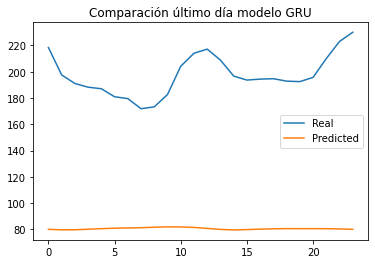

In [32]:
plt.plot(y_test[((y_test.size) - 24):], label='Real')
plt.plot(y_pred_gru[((y_test.size) - 24):], label='Predicted')
plt.title("Comparación último día modelo GRU")
plt.legend()

In [33]:
rmse_lstm = np.sqrt(mean_squared_error(y_test, y_pred_lstm))
mae_lstm = mean_absolute_error(y_test, y_pred_lstm)
rmse_cnn = np.sqrt(mean_squared_error(y_test, y_pred_cnn))
mae_cnn = mean_absolute_error(y_test, y_pred_cnn)
rmse_gru = np.sqrt(mean_squared_error(y_test, y_pred_gru))
mae_gru = mean_absolute_error(y_test, y_pred_gru)

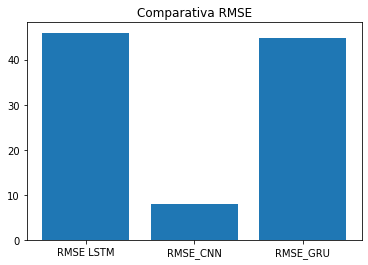

In [34]:
x_axis = ["RMSE LSTM", "RMSE_CNN", "RMSE_GRU"]
y_axis = [rmse_lstm, rmse_cnn, rmse_gru]
plt.title("Comparativa RMSE")
plt.bar(x_axis, y_axis)
plt.show()

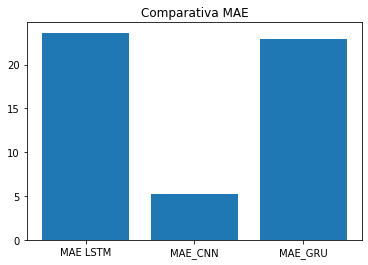

In [35]:
x_axis = ["MAE LSTM", "MAE_CNN", "MAE_GRU"]
y_axis = [mae_lstm, mae_cnn, mae_gru]
plt.title("Comparativa MAE")
plt.bar(x_axis, y_axis)
plt.show()

In [36]:
model_lstm.save("no_normalized_only_price/lstm.h5")
model_cnn.save("no_normalized_only_price/cnn.h5")
model_gru.save("no_normalized_only_price/gru.h5")